## Image Processing

Before we do anything serious with machine learning, lets try to clean up the images as much as possible. To start, we can define a cutoff and make everything either black or white.

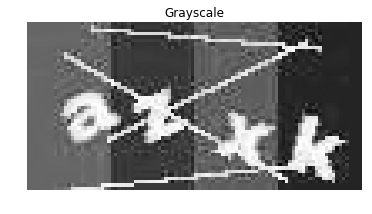

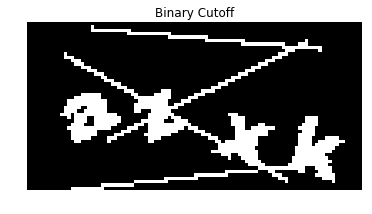

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from full.misc import showImg

# Size of input CAPTCHA
IM_W, IM_H = 100, 50
S = (IM_H, IM_W)
# Luminosity cutoff for what we keep
LIGHTNESS_CUTOFF = 170

im = Image.open('imgs/captcha.png')
im = im.convert('L') # Make grayscale
showImg(im, 'Grayscale')
pix = np.array(im.getdata())
# Apply cutoff
pix = np.array(list(map(lambda x: 255 if x > LIGHTNESS_CUTOFF else 0, pix)))
showImg(pix.reshape(S), 'Binary Cutoff')

Next up, wouldn't it be nice if we could get rid of those lines? Although perhaps a bit unrealistic, the captchas for the problem all had lines in the exact same place for a given user. Because of this, you can go through a sample of images and find the pixels that are always white, giving you just the lines.

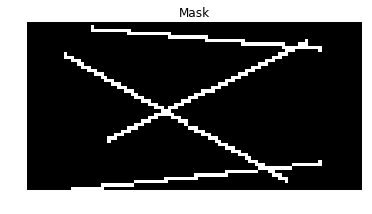

In [2]:
def generateMask():
    ''' Given a directory of imgs with only 0/255 pixel values,
        finds pixels that are always white and outputs a mask
        with those values.
    '''
    mask = np.ones([HEIGHT*WIDTH], dtype=np.uint8)
    for im in getImgs():
        arr = np.array(im.getdata(), dtype=np.uint8)
        mask  &= arr
    return mask * 255
im = Image.open('imgs/mask.png')
showImg(im, "Mask")
mask = np.array(im.getdata())

Now we can remove the lines, however that cuts up our letters and doesn't look too great. Lets try restoring some of the removed areas if they have a lot of other pixels around them.

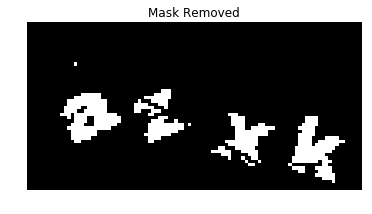

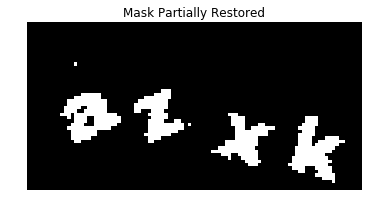

In [3]:
# Apply mask
pix ^= mask
pix = pix.reshape(S)
showImg(pix, "Mask Removed")

# Get white pixel coords from mask
mask = mask.reshape(S)
ps = [(x,y)
      for y, row in enumerate(mask)
      for x, p in enumerate(row)
      if p == 255]

# Restore wrongly masked pix
valid = lambda x, y: x >= 0 and x < IM_W and y >= 0 and y < IM_H
for x, y in ps:
    total = 0
    
    # Loop over 9x9 area surrounding pix
    DELTAS = [(dx, dy) for dx in range(-1,2) for dy in range(-1,2)]
    for dx, dy in DELTAS:
        tx, ty = x + dx, y + dy
        if valid(tx, ty) and pix[ty][tx] != 0:
            total += 1

    # Add if surrounded 
    if total >= 4:
        pix[y][x] = 255

showImg(pix, "Mask Partially Restored")

Looks pretty good! Now lets work on isolating the characters; it'll be a lot easier to classify them individually than it would be to try to classify all four as a whole. Most characters are a single continous area, so lets use flood fill to pick those out. We can erase any pixel groups that are too small, clearing out some noise.

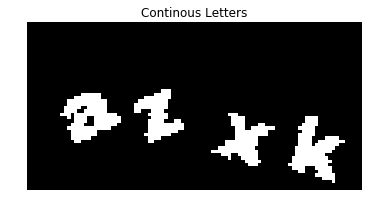

In [4]:
def findWhite(im):
    ''' Finds first white pixel in image.
        Note: This could be sped up by passing in the last coordinate,
        however I didn't run into performance issues so didn't worry about it.
    '''
    t = im.T # Iterate from left to right rather than top to bottom
    for y, row in enumerate(t):
        for x, p in enumerate(row):
            if p == 255:
                return (y,x)
    return None

from queue import Queue
MIN_GROUP_SIZE = 10
def fill(data, x, y, target, replacement):
    ''' Fills a continous area of target color with replacement,
        starting at (x, y).
        Returns a set of pixels mutated. 
    '''
    if data[y][x] != target:
        return

    q = set()
    allP = set()
    valid = lambda x, y: x >= 0 and x < IM_W and y >= 0 and y < IM_H and data[y][x] == target
    q.add((x,y))
    allP.add((x,y))
    while len(q):
        x, y = q.pop() # Get next
        data[y][x] = replacement

        # Iterate around 9x9 area
        for dx, dy in DELTAS:
            tx, ty = x + dx, y + dy
            if valid(tx, ty) and not (tx == x and ty == y):
                q.add((tx,ty))
                allP.add((tx, ty))

    # Don't keep areas smaller than MGS
    if len(allP) < MIN_GROUP_SIZE:
        for x, y in allP:
            data[y][x] = 0
        return None
    return allP

parts = []
while True:
    r = findWhite(pix)
    if not r:
        break
    x, y = r
    res = fill(pix, x, y, 255, 100)

    if res:
        parts.append(res)
assert len(parts) == 4 # Only continue if we have 4 regions
    
showImg(pix, "Continous Letters")

Now sometimes we might get CAPTCHAs where two letters are touching or have an `i` or `j` with the dot cleanly disattached from the stem, giving us fewer or greater than 4 groups. Thankfully these only ocur about 40% of the time. The problem only requires us to submit 10k valid captcha answers, so we can choose which ones we decide to send, allowing us to ignore some of the less ideal inputs.

Now that we have our letters lets crop and line them up nicely. We want them all to be in boxes of the same size so its easier to classify them. If they don't fit in a box size that fits most, they're probably hard images anyways so we'll skip those.

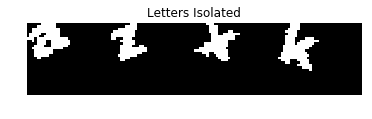

In [12]:
# Size of character boxes
# Some might go out of these bounds, but in
# that case they're probably hard anyway so we'd skip
OUT_H, OUT_W = 30, 35

mats = []
for i, part in enumerate(parts):
    minX, minY = 101, 101
    # Get min (x,y)
    for (x,y) in part:
        if x < minX:
            minX = x
        if y < minY:
            minY = y
    
    # Paste into new box
    mat = np.zeros([OUT_H, OUT_W], dtype=np.uint8)
    for x, y in part:
        mat[y-minY][x-minX] = 255
    mats.append(mat)

showImg(np.concatenate(mats, axis=1), "Letters Isolated")

## Machine Learning

Now to start on the classifier. K-means clustering appealed to me at first since I didn't want to hand annotate examples for supervised learning. However, a quick run at it using `sklearn` went poorly so I trashed the idea and decided on CNNs.

First lets define our model. The problem feels pretty similar to MNIST, so lets go with adapted version of that, just changing the input and output shapes. We'll be passing in a `30 x 35` image and outputting a `1 x 36` vector of probabilities, one for each lowercase letter and digit.

In [6]:
import tensorflow as tf
import string

# Our string of chars to map index <-> char
look = string.ascii_lowercase + string.digits

# Straight out of my CNN code for MNIST
INPUT_SIZE, OUTPUT_SIZE = OUT_H * OUT_W, len(look) 
FILTER_SIZE, FILTER_ONE_DEPTH, FILTER_TWO_DEPTH = 5, 32, 64
FLAT_SIZE, HIDDEN_SIZE = 8 * 9 * 64, 1024

# Create Convolution/Pooling Helper Functions 
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

initializer = tf.contrib.layers.xavier_initializer()
# Setup Placeholders => None argument in shape lets us pass in arbitrary sized batches
X = tf.placeholder(tf.float32, shape=[None, INPUT_SIZE], name="X")  
Y = tf.placeholder(tf.float32, shape=[None, OUTPUT_SIZE], name="Y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# Reshape input so it resembles an image (height x width x depth)
X_image = tf.reshape(X, [-1, OUT_H, OUT_W, 1])

# Conv Filter 1 Variables
Wconv_1 = tf.get_variable("WConv_1", shape=[FILTER_SIZE, FILTER_SIZE,
                                            1, FILTER_ONE_DEPTH], initializer=initializer)
bconv_1 = tf.get_variable("bConv_1", shape=[FILTER_ONE_DEPTH], initializer=initializer)
# First Convolutional + Pooling Transformation
h_conv1 = tf.nn.relu(conv2d(X_image, Wconv_1) + bconv_1)
h_pool1 = max_pool_2x2(h_conv1)

# Conv Filter 2 Variables
Wconv_2 = tf.get_variable("WConv_2", shape=[FILTER_SIZE, FILTER_SIZE,
                                            FILTER_ONE_DEPTH, FILTER_TWO_DEPTH],
                          initializer=initializer)
bconv_2 = tf.get_variable("bConv_2", shape=[FILTER_TWO_DEPTH], initializer=initializer)
# Second Convolutional + Pooling Transformation
h_conv2 = tf.nn.relu(conv2d(h_pool1, Wconv_2) + bconv_2)
h_pool2 = max_pool_2x2(h_conv2)

# Flatten Convolved Image, into vector for remaining feed-forward transformations
h_pool2_flat = tf.reshape(h_pool2, [-1, FLAT_SIZE])
# Hidden Layer Variables
W_1 = tf.get_variable("W_1", shape=[FLAT_SIZE, HIDDEN_SIZE], initializer=initializer)
b_1 = tf.get_variable("b_1", shape=[HIDDEN_SIZE], initializer=initializer)

# Hidden Layer Transformation
hidden = tf.nn.relu(tf.matmul(h_pool2_flat, W_1) + b_1)
# DROPOUT - For regularization
hidden_drop = tf.nn.dropout(hidden, keep_prob)

# Output Layer Variables
W_2 = tf.get_variable("W_2", shape=[HIDDEN_SIZE, OUTPUT_SIZE], initializer=initializer)
b_2 = tf.get_variable("b_2", shape=[OUTPUT_SIZE], initializer=initializer)

# Output Layer Transformation
output = tf.add(tf.matmul(hidden_drop, W_2), b_2, name='output')

# Compute Loss
loss = tf.losses.softmax_cross_entropy(Y, output)
# Compute Accuracy
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(output, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Setup Optimizer
train_op = tf.train.AdamOptimizer().minimize(loss)

Next up is training. We'll define a function to pipe in our data and then iterate until we get good accuracy.

In [9]:
import random
import json
def loadData(batch_size):
    ''' Creates batch generators for train and test from
        annotated data described in 'chars.json'.
    '''
    with open('chars.json') as f:
        data = list(json.load(f).items())
    random.shuffle(data) # Shuffle for good luck
    print("{} DATA POINTS".format(len(data)))
    imgs = []
    for fn, c in data:
        # Skip chars I entered nothing for
        if not c: continue
        im = Image.open(f'static/chars/{fn}')
        # Normalize pix vals to [-1, 1]
        norm_pix = (np.array(im.getdata(), dtype=np.float32) / 255) * 2 - 1 
        # Create one-hot label vector
        vector_c = np.zeros(len(look))
        vector_c[look.index(c)] = 1
        imgs.append((norm_pix, vector_c))
    
    # Have a 80/20 train/test split
    split_ind = 4*len(imgs)//5
    train = imgs[:split_ind]
    test = imgs[split_ind+1:]
    test_x, test_y = zip(*test)
    def gen(data):
        while True:
            batch = []
            for i, p in enumerate(data):
                batch.append(p)
                i += 1
                if i % batch_size == 0:
                    yield zip(*batch)
                    batch = []
    return gen(train), test_x, test_y

BATCH_SIZE = 30
NUM_ITERS = 1000
train, test_x, test_y = loadData(BATCH_SIZE)

### Launch the Session, to Communicate with Computation Graph ###
sess = tf.InteractiveSession()
# Initialize all variables in the graph
sess.run(tf.global_variables_initializer())

# Training Loop
for i in range(NUM_ITERS):
    batch_x, batch_y = next(train)
    curr_acc, _ = sess.run([accuracy, train_op], feed_dict={X: batch_x,
                                                            Y: batch_y,
                                                            keep_prob: 0.5})
    if i % 100 == 0:
        print('Step {} Current Training Accuracy: {:.3f}'.format(i, curr_acc))

# Evaluate on Test Data
# keep-prop = 1.0 to disable dropout
print('Test Accuracy: {:.3f}'.format(sess.run(accuracy, feed_dict={X: test_x, 
                                                            Y: test_y,
                                                            keep_prob: 1.0}))) 

1292 DATA POINTS
Step 0 Current Training Accuracy: 0.100
Step 100 Current Training Accuracy: 0.967
Step 200 Current Training Accuracy: 1.000
Step 300 Current Training Accuracy: 1.000
Step 400 Current Training Accuracy: 1.000
Step 500 Current Training Accuracy: 1.000
Step 600 Current Training Accuracy: 1.000
Step 700 Current Training Accuracy: 1.000
Step 800 Current Training Accuracy: 1.000
Step 900 Current Training Accuracy: 1.000
Test Accuracy: 0.968


One thing I brushed over was actual training examples. I thought this was going to be the most tedious part, but it wasn't bad at all. I made a quick webserver in Flask which would serve me characters to classify. The webserver serves the images from `static/chars` which is generated by writing out the isolated characters from `mats` into `<char index>_<captcha name>.png`.

In less than half an hour, I had 1k examples of characters which was enough to get good accuracy. I think one reason for the high performance on relatively little data is the fact that the CAPTCHA text comes from a font with very regular style, unlike handwritten MNIST digits.

<img style='display:block;margin:auto;' src='imgs/captcha_webserver.png'>

In [ ]:
from flask import Flask, render_template, request, redirect
import os, json
app = Flask(__name__)

data = {}
with open('chars.json') as f:
    data = json.load(f)

# Get all saved character files
files = set(
    filter(
        lambda x: x.endswith('.png'),
        os.listdir('static/chars')))

def getFile():
    ''' Returns the filename of an unannotated char. '''
    s = files - set(data.keys())
    return s.pop()

@app.route('/save')
def save():
    ''' Saves out char.json & redirects back to index. '''
    with open('chars.json', 'w') as f:
        json.dump(data, f)
    return redirect('/')

@app.route('/', methods=['GET', 'POST'])
def main():
    ''' Index handler. '''
    # If POST'd save annotation
    if request.method == 'POST':
        fn, c = request.form['file'], request.form['txt']
        data[fn] = c
    # Serve up new file
    newFile = getFile()
    return render_template('main.html', name=newFile, img=f'/static/chars/{newFile}')

Now that our model is working, lets start answering CAPTCHAs! We'll just load in our pretrained model, split up our image, classify each character, and return the result.

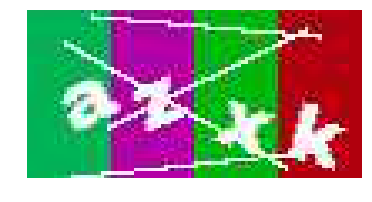

CAPTCHA: azxk


In [17]:
def predict(inp):
    probs = sess.run(output, feed_dict={X: inp, keep_prob: 1.0})
    ret = ''
    for prob in probs:
        ret += look[np.argmax(prob)]
    return ret

norm_mats = list(map(lambda x: (x.flatten() / 255) * 2 - 1, mats))
pred = predict(norm_mats)
showImg(Image.open('imgs/captcha.png'),'')
print(f"CAPTCHA: {pred}")

## Conclusion

I was able to generate the 15k CAPTCHAs in about 10min and submitted them without any issues. Later, I found out the way the CAPTCHAs were generated from someone. From this I calculated that of those that I didn't skip, I got 86% accuracy, and including skips had 56% accuracy. Not bad!

I really enjoyed this problem as it was relatively realistic; you definitely see CAPTCHAs similar to these on old janky websites. It speaks to the flexibility of both Python and TensorFlow that I was able to go start to finish on the problem in under a day. It still amazes me how adaptable neural nets are and how easy it is to tweak a model arcitecture to work for a variety of tasks.